In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

data = pd.read_csv("dataset/preprocessed.csv")



/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/ens

In [2]:
data_npWNan = data.iloc[:, :].values

data_np = data_npWNan[data_npWNan[:,-1]!= -1 ]
unique_elements, counts_elements = np.unique(data_np[:,-1], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     1      2      3      4      5]
 [ 78815  87257 136412 183844 275766]]


In [3]:
print("feature " + str(data_np.shape))

feature (762094, 44)


In [4]:
feature = data_np[:, :-1]
target = data_np[:, -1]

In [5]:
target -= 1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 0)

In [7]:
X_train.shape

(609675, 43)

In [8]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 62846  69846 109216 147032 220735]]


In [9]:
sm = SMOTETomek(random_state = 27, n_jobs = -1)

X_train, y_train = sm.fit_sample(X_train, y_train)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [10]:
X_train.shape

(955513, 43)

In [11]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [204152 195863 187569 181912 186017]]


In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)

In [14]:
params = {}
params['learning_rate'] = 0.5
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_class'] = 5
params['sub_feature'] = 0.5
params['num_leaves'] = 30
params['min_data'] = 40
params['max_depth'] = 9
# params['device'] = 'gpu'

In [15]:
import datetime
a = datetime.datetime.now().replace(microsecond=0)
clf = lgb.train(params, d_train, 3500)
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

0:07:43


In [16]:
#Prediction
import datetime
a = datetime.datetime.now().replace(microsecond=0)
y_pred=clf.predict(X_test)
print(y_pred.shape)
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

(152419, 5)
0:00:39


In [17]:
print(np.argmax(y_pred, axis=1))
prediction = np.argmax(y_pred, axis=1)

[0 1 0 ... 1 0 1]


In [18]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(prediction,y_test)
accuracy*100

56.3591153333902

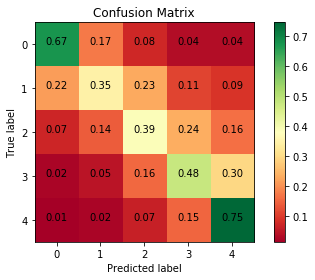

array([[0.67480744, 0.17490137, 0.07621016, 0.03700921, 0.03707183],
       [0.21578313, 0.34794096, 0.22962495, 0.11308943, 0.09356154],
       [0.07339315, 0.14123401, 0.38597588, 0.23547581, 0.16392116],
       [0.02352494, 0.0471857 , 0.15704118, 0.47704553, 0.29520265],
       [0.01437372, 0.0233323 , 0.06507241, 0.15200523, 0.74521633]])

In [19]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
plt.show()
cm




In [20]:
a=275766
total = 78815 + 87257 +136412+ 183844 +275766
print(a/total)

0.3618529997611843


In [21]:
# en iyi learning 0.5 civari
# iteration 3500 iyi
# min_data = 40
# max_depth = 9

In [22]:

count=7

In [ ]:
for x in range(1):
    a = datetime.datetime.now().replace(microsecond=0)
    params = {}
    params['learning_rate'] = 0.5
    
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = 5
    params['sub_feature'] = 0.5
    params['num_leaves'] = count
    params['min_data'] = 40
    params['max_depth'] = 9
    # params['device'] = 'gpu'
    clf = lgb.train(params, d_train, 800)
    
    y_pred=clf.predict(X_test)    
    
    prediction = np.argmax(y_pred, axis=1)
    
    from sklearn.metrics import accuracy_score
    accuracy=accuracy_score(prediction,y_test)
    print(count,"  icin acur ",accuracy*100)
    b = datetime.datetime.now().replace(microsecond=0)
    print(x," ",count," icin suresi",b-a,"\n")
    count += 1
